In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import seaborn as sns


from pathlib import Path
from typing import Dict

In [2]:
OUTPUT_DIR = f"{Path.cwd()}/high_tail_latency_output"
MODEL_NAME = "01-ai/Yi-34B-200K"
TP_DIMENSION = 2
TRACES = [
    { 
        "name": "openchat/openchat_sharegpt4_dataset_filtered",
        "length_provider": "trace",
        "trace_file": "./data/processed_traces/sharegpt_8k_filtered_stats_llama2_tokenizer.csv",
        "num_requests": 128,
        "max_seq_length": 8192
    }
]
SCHEDULERS = [
    { "type": "vllm", "chunk_size": None, "max_batch_size": 256 },
    { "type": "sarathi", "chunk_size": 1536, "max_batch_size": 256},
]
# QPS = [1.0]
QPS = [0.55, 0.7, 1.0]

In [3]:
def generate_runs():
    devices = ','.join([str(x) for x in range(TP_DIMENSION)])
    commands = []
    for trace in TRACES:
        for qps in QPS:
            for scheduler in SCHEDULERS:
                base_command = (
                    f"CUDA_VISIBLE_DEVICES={devices} python sarathi/benchmark/main.py \\\n"
                    f"--output_dir {OUTPUT_DIR} \\\n"
                    f"--model_name {MODEL_NAME} \\\n"
                    f"--model_max_model_len {trace['max_seq_length']} \\\n"
                    f"--cluster_num_replicas 1 \\\n"
                    f"--model_tensor_parallel_degree {TP_DIMENSION} \\\n"
                    f"--model_pipeline_parallel_degree 1 \\\n"
                    f"--request_generator_provider synthetic \\\n"
                    f"--synthetic_request_generator_interval_provider poisson \\\n"
                    f"--poisson_request_interval_generator_qps {qps} \\\n"
                    f"--synthetic_request_generator_num_requests {trace['num_requests']} \\\n"
                    f"--synthetic_request_generator_length_provider trace \\\n"
                    f"--trace_request_length_generator_trace_file {trace['trace_file']} \\\n"
                    f"--trace_request_length_generator_max_tokens {trace['max_seq_length']} \\\n"
                    f"--trace_request_length_generator_prefill_scale_factor 1 \\\n"
                    f"--trace_request_length_generator_decode_scale_factor 1 \\\n"
                    f"--metrics_store_keep_individual_batch_metrics true \\\n"
                    f"--metrics_store_enable_op_level_metrics false \\\n"
                )
                if scheduler['type'] == "vllm":
                    command = base_command + (
                        f"--replica_scheduler_provider vllm \\\n"
                        f"--replica_scheduler_max_batch_size {scheduler['max_batch_size']} \\\n"
                        f"--vllm_scheduler_max_tokens_in_batch {trace['max_seq_length']} \n"
                    )
                elif scheduler['type'] == "sarathi":
                    command = base_command + (
                        f"--replica_scheduler_provider sarathi \\\n"
                        f"--replica_scheduler_max_batch_size {scheduler['max_batch_size']} \\\n"
                        f"--sarathi_scheduler_chunk_size {scheduler['chunk_size']} \\\n"
                        f"--sarathi_scheduler_enable_rolling_prefills true \\\n"
                        f"--sarathi_scheduler_enable_dynamic_chunking_schedule false\n"
                    )
                commands.append(command)
    with open(f"high_tail_latency.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("set -x\n")
        for command in commands:
            f.write(command + "\n")


In [4]:
def _get_run_directories():
    rootdir = Path(OUTPUT_DIR)
    subdirectory_list = [
        directory for directory in rootdir.iterdir() if directory.is_dir()
    ]
    return subdirectory_list

In [5]:
def _get_df():
    run_directories = _get_run_directories()
    run_directories.sort()

    datapoints = []

    for run_dir in run_directories:
        try:
            with open(
                f"{run_dir}/benchmark_config.yml", "r"
            ) as benchmark_config_file, open(
                f"{run_dir}/replica_0/plots/decode_token_execution_plus_preemption_time.csv", "r"
            ) as tbt_file:
                benchmark_config = yaml.safe_load(benchmark_config_file)
                tbt_df = pd.read_csv(tbt_file)

                scheduler = benchmark_config["replica_scheduler_provider"]
                if scheduler == "sarathi":
                    scheduler += f"_{benchmark_config['sarathi_scheduler_chunk_size']}"
                qps = benchmark_config["poisson_request_interval_generator_qps"]
                
                datapoints.append({
                    "scheduler": scheduler,
                    "qps": qps,
                    "tail_latency": tbt_df["decode_token_execution_plus_preemption_time"].quantile(0.99)
                })
        except FileNotFoundError as e:
            print(f"WARN: Skipping {run_dir} due to {e}")
    return pd.DataFrame(datapoints)


In [6]:
def plot():
    df = _get_df()
    # sns.set_theme(style="whitegrid")
    sns.barplot(data=df, x='qps', y='tail_latency', hue='scheduler')
    plt.show()

In [7]:
# generate_runs()

WARN: Skipping /home/amey/llm-batching/osdi-experiments/figure-1/high_tail_latency_output/2024-04-25_17-34-02-736375 due to [Errno 2] No such file or directory: '/home/amey/llm-batching/osdi-experiments/figure-1/high_tail_latency_output/2024-04-25_17-34-02-736375/replica_0/plots/decode_token_execution_plus_preemption_time.csv'


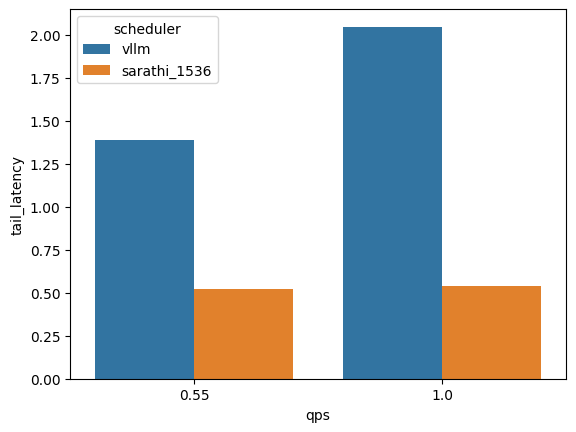

In [8]:
plot()